# 2. *A/B test*

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


| user_id | revenue | testgroup |
|---------|---------|-----------|
|       1 |       0 |         b |
|       2 |       0 |         a |
|       3 |       0 |         a |
|       4 |       0 |         b |
|       5 |       0 |         b |


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep = ';')

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
groups = (df.groupby('testgroup')
           .agg({'user_id': 'nunique'})
           .rename(columns={'user_id': 'users'}))                       

In [5]:
paid_groups = (df.query('revenue > 0')
                .groupby('testgroup')
                .agg({'user_id': 'nunique',
                      'revenue': sum})
                .rename(columns={'user_id': 'paid_users',
                                 'revenue': 'total_revenue'}))

In [6]:
groups = groups.merge(paid_groups, on='testgroup').reset_index()

In [7]:
groups.head()

,testgroup,users,paid_users,total_revenue
0,a,202103,1928,5136189
1,b,202667,1805,5421603


**Посмотрим на конверсию, общую выручку и выручку на пользователя**

In [8]:
user_info = groups.assign(ARPU = round(groups.total_revenue  / groups.users, 2), 
                          ARPPU = round(groups.total_revenue / groups.paid_users, 2),
                          CR = round(100 * groups.paid_users / groups.users, 2))
user_info

,testgroup,users,paid_users,total_revenue,ARPU,ARPPU,CR
0,a,202103,1928,5136189,25.41,2664.00,0.95
1,b,202667,1805,5421603,26.75,3003.66,0.89


**ARPU в тестовой группе(группа B) выше на 5%, чем в контрольной(группа A), но конверсия меньше. Значимость полученных различий будем определять используя  бутстреп для ARPU и критерий хи-квадрат Пирсона для CR. Уровень значимости α примем равным 0.05**

H0:  никакой разницы на самом деле нет, различия случайны

H1: разница есть, различия не случайны

In [9]:
data_pv = df.reset_index().pivot_table(columns='testgroup', values='revenue', index='user_id')
data_pv.head()

testgroup,a,b
user_id,,
1,NaN,0.0
2,0.0,NaN
3,0.0,NaN
4,NaN,0.0
5,NaN,0.0


In [10]:
a = data_pv.a.dropna()
b = data_pv.b.dropna()
a = a[a > 0]
b = b[b > 0]

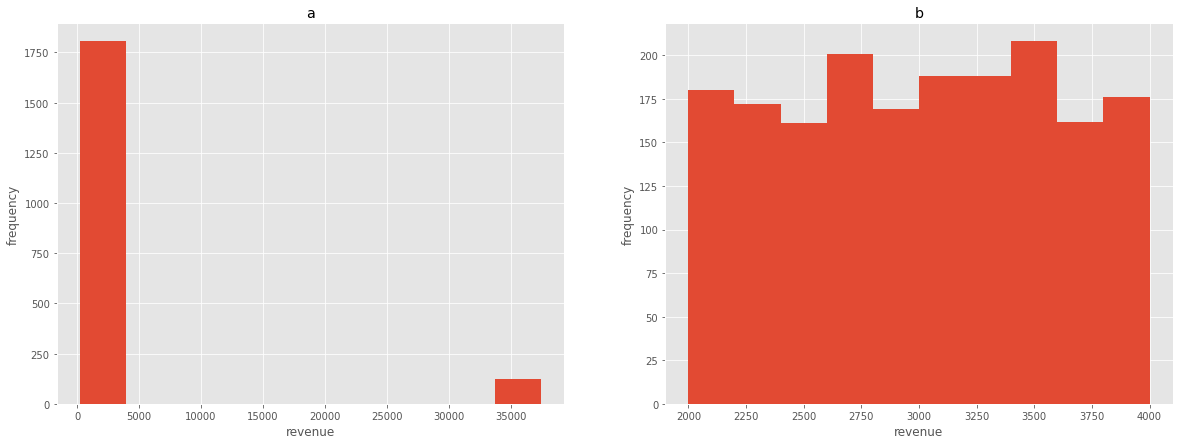

In [11]:
plt.figure(figsize=(20, 7))
plt.style.use('ggplot')
for i,group in enumerate([a, b]):
    plt.subplot(1, 2, i+1)
    plt.title(group.name)
    plt.xlabel('revenue')
    plt.ylabel('frequency')
    plt.hist(group)

**Тех, кто тратит >30K всего 6% от числа всех пользователей, но они приносят 90% выручки, поэтому будем работать с данными "как есть"**

In [12]:
def get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    '''
    Функция для проверки гипотез с помощью бутстрапа
    
        Параметры
        ---------        
            data_column_1: числовые значения первой выборки
            data_column_2: числовые значения второй выборки
            boot_it : количество бутстрэп-подвыборок
            statistic : интересующая нас статистика
            bootstrap_conf_level : уровень значимости
            
        Возвращает
        ----------
            boot_data: посчитанная статистика
            ci: границы доверительного интервала
            p_value: p-value                        
    '''
    
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(boot_len, replace = True).values        
        samples_2 = data_column_2.sample(boot_len, replace = True).values        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2        

    plt.figure(figsize=(16, 5))
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=100, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

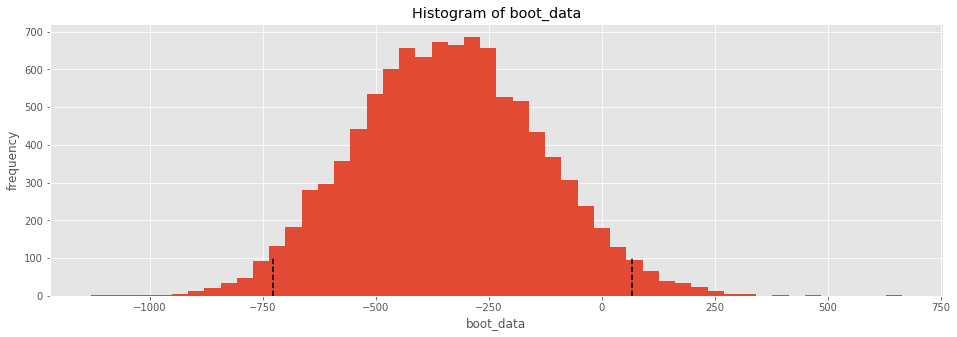

In [13]:
booted_data = get_bootstrap(a, b, boot_it = 10000)

In [14]:
p_value = booted_data['p_value']
p_value

0.09739987622628116

**p-value > 0.05** 

**У нас нет достаточных оснований для отклонения нулевой гипотезы**

In [15]:
user_info

,testgroup,users,paid_users,total_revenue,ARPU,ARPPU,CR
0,a,202103,1928,5136189,25.41,2664.00,0.95
1,b,202667,1805,5421603,26.75,3003.66,0.89


In [16]:
chi2_table = (user_info[['users', 'paid_users']]
              .assign(not_paid_users = user_info.users - user_info.paid_users )[['paid_users', 'not_paid_users']])
chi2_table

,paid_users,not_paid_users
0,1928,200175
1,1805,200862


In [17]:
p_value = (chi2_contingency(chi2_table)[1]).round(3)
p_value

0.036

**p-value < 0.05** 

**У нас есть основания для отклонения нулевой гипотезы**

**Различие конверсии между контрольной и тестовой группой статистически значимо**

# Выводы
****
**1. Различные наборы акционных предложений повлияли на характер трат пользователей по разному. ARPU, ARPPU и полная выручка выше в тестовой группе, но конверсия ниже чем в контрольной**

**2. В тестовой группе имеются 6% пользователей, которые принесли 90% выручки. Возможные причины:**
  * Низкое качество системы сплитования. В одну группу попали пользователи готовые покупать дорогие пакеты, в другую - нет
  * Большой ценовой разброс акционных пакетов. Например, в контрольной группе пакеты предлагаются либо по низкой, либо по средней цене, что позволяет бОльшему числу пользователей воспользоваться этим предложением. В тестовой же группе цена пакетов средне-высокая. Часть пользователей была не готова к высокой цене, поэтому конверсия просела.
  
**3. Статистика не даёт однозначного ответа на вопрос: "какие пакеты в конечном итоге стоит предлагать пользователям?". Возможно, нужен более глубокий анализ сегментов пользователей и различные акции для каждого сегмента. Однако, если решение всё-таки необходимо принять, я более склонен считать, что стОит раскатить результаты тестовой группы на всех пользователей**